## Classifying Dogs-vs-Cats with InceptionV3

The notebook yesterday attempted to classify Dogs-vs-Cats by building a small CNN and training from scratch.  The accuracy on the small dataset was not spectacular, topping out at about 80%.

To increase the accuracy and practice implementing transfer learning, I'm going to use the InceptionV3 model pretrained on the Imagenet dataset.

In [1]:
import os
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# inception model is already saved locally
inception = load_model(os.path.join(base_dir, 'inception_model.h5'))

datagen = ImageDataGenerator(rescale=1./255) #convert pixel values from 0-255 to 0-1
batch_size = 20

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Program Files\Anaconda3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [2]:
inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
# preprocess the features using the inception model
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = inception.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
# flatten preprocessed features and save to file
train_features = np.reshape(train_features, (2000, 3 * 3 * 2048))
np.save(os.path.join(base_dir, 'train_features_inception'), train_features)
validation_features = np.reshape(validation_features, (1000, 3 * 3 * 2048))
np.save(os.path.join(base_dir, 'validation_features_inception'), validation_features)
test_features = np.reshape(test_features, (1000, 3 * 3 * 2048))
np.save(os.path.join(base_dir, 'test_features_inception'), test_features)

In [12]:
# Implement the final layers of the model
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import RMSprop

def get_model():
    inputs = Input((3 * 3 * 2048,))
    X = Dense(256, activation='relu')(inputs)
    X = Dropout(0.5)(X)
    outputs = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(lr=1e-4),
                 metrics=['acc'])
    
    return model

model = get_model()

In [13]:
# Train the final layers using the preprocessed features
history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.5139 - acc: 0.8925 - val_loss: 0.3500 - val_acc: 0.9260
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2248 - acc: 0.9495 - val_loss: 0.1787 - val_acc: 0.9610
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2044 - acc: 0.9525 - val_loss: 0.2849 - val_acc: 0.9550
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1686 - acc: 0.9610 - val_loss: 0.2221 - val_acc: 0.9550
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1230 - acc: 0.9670 - val_loss: 0.3947 - val_acc: 0.9460
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1033 - acc: 0.9795 - val_loss: 0.3906 - val_acc: 0.9550
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0957 - acc: 0.9790 - val_loss: 0.3170 - val_acc: 0.9570
Epoch 8/30
200

In [20]:
test_results = model.evaluate(test_features, test_labels)

1000/1000 [==============================] - 1s 500us/step


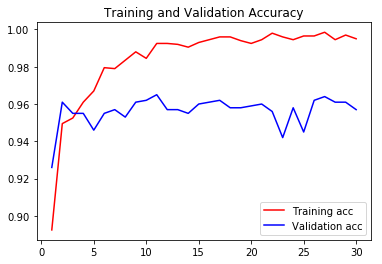

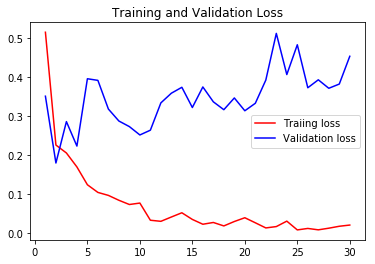

Test accuracy:  0.952


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_acc_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'r', label='Traiing loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()
    
plot_acc_and_loss(history)
print('Test accuracy: ', test_results[1])

## Results

Using the inception model is a large improvement from yesterday's CNN, with accuracy increasing from 80% to 95%. However, looking at the validation accuracy after retraining the final layer of inception, it doesn't look like training actually did much in this case.

The validation accuracy bounces between 94-96% accuracy for almost all of the training. I assume this is a result of the inception model already being trained on dog/cat pictures as part of the imagenet dataset, so the two layers I added on were able to train in very few epochs.